## 載入套件

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

## 單價相關係數

In [2]:
# 讀取資料
'''
此份檔案為2.Preproc_modeling 中前處理完成後之資料
(train_x, train_y, valid_x, valid_y)

為準確地反映相關係數的狀況，並未對特徵進行quantisation
'''

with open('final_version_preproc_data_noq.pkl', 'rb') as f:
    train_x, train_y, valid_x, valid_y = pickle.load(f)

In [3]:
total_df = pd.concat([train_x, valid_x])
total_df['單價'] = pd.concat([train_y, valid_y])
total_df.shape

(11749, 517)

In [4]:
# 逐次取每個特徵，移除遺漏值(固定為-1)後與單價計算相關係數

corr_ls = []
c_ls = []
for c in total_df.columns:
    if c=='單價':
        continue
    corr_ls.append(total_df[total_df[c]>0][['單價', c]].corr()['單價'].iloc[1])
    c_ls.append(c)


In [5]:
# 與單價相關係數最高的30個特徵
pd.DataFrame({'columns':c_ls, 'corr':corr_ls}).dropna().sort_values('corr').tail(30)

,columns,corr
44,price_sd_屋齡_型態_移轉層次,0.789123
23,price_sd_移轉,0.789154
31,price_sd_屋齡_型態,0.798052
103,price_sd_型態,0.806938
113,price_sd_屋齡,0.810949
107,total_price_型態,0.811513
143,price_路名_rev,0.823073
150,price_型態_rev,0.842823
286,price_屋齡_neighbor_mean1,0.858809
284,price_精準_neighbor_mean1,0.871824


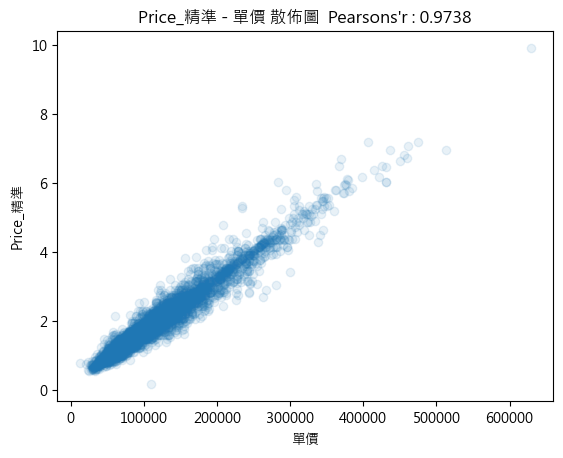

In [6]:
# 取 Price_精準 (實價登錄衍生特徵中相關係數最高者) 繪製散佈圖

plt.scatter(total_df[total_df['price_精準']>0]['price_精準'],
            total_df[total_df['price_精準']>0]['單價'], alpha = 0.1)
plt.title(f'Price_精準 - 單價 散佈圖  Pearsons\'r : 0.9738')
plt.xlabel('單價')
plt.ylabel('Price_精準')
plt.show()

In [7]:
# 計算不同篩選條件下之實價登錄衍生特徵(以price做代表)之未配對比例

out_list = []
c_list = []
for c in train_x.filter(regex='price'):
    out_list.append(np.mean(total_df[c]<0))
    c_list.append(c)

pd.DataFrame({'columns':c_list, 'non_mapping_percent':out_list})

,columns,non_mapping_percent
0,price_精準,0.551281
1,price_sd_精準,0.828411
2,price_skew_精準,0.865606
3,total_price_精準,0.551281
4,parking_price_精準,0.551281
...,...,...
72,ref_price_路名_屋齡,0.454422
73,ref_price_路名_型態_型態,0.518172
74,ref_price_型態_移轉,0.381309
75,ref_price_路名_型態_路名_型態_屋齡,0.381735


## 模型表現差異測試
以不同特徵組合測試模型表現

In [8]:
# 讀取資料
'''
此份檔案為2.Preproc_modeling 中前處理完成後之資料
(train_x, train_y, valid_x, valid_y)

包含 feature quantisation
'''


with open('final_version_preproc_data.pkl', 'rb') as f:
    train_x, train_y, valid_x, valid_y = pickle.load(f)

In [9]:
print(train_x.shape, valid_x.shape)

(9399, 516) (2350, 516)


In [10]:
def featureset_scores(use_cols):
    
    seeds_list = [630, 810, 521, 806, 107]
    n_repeat = len(seeds_list)
    
    train_mape_list = []
    valid_mape_list = []
    
    for i in range(n_repeat):
        model = LGBMRegressor(n_estimators=10000, learning_rate=5e-2, reg_alpha = 1e-2, reg_lambda = 5e-1, max_depth=12,
                  importance_type="gain", objective='mse', min_child_samples=3, random_state = seeds_list[i],
                  subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
        
        model.fit(train_x.iloc[:,use_cols], train_y)
        
        train_pred = model.predict(train_x.iloc[:,use_cols])
        valid_pred = model.predict(valid_x.iloc[:,use_cols])
        
        train_mape_list.append(mean_absolute_percentage_error(y_true = train_y, y_pred = train_pred))
        valid_mape_list.append(mean_absolute_percentage_error(y_true = valid_y, y_pred = valid_pred))
    
    return train_mape_list, valid_mape_list

### 不同來源之特徵差異比較

In [11]:
# 原始特徵
origin_feature = list(range(0, 12)) + list(range(342, 511))

# 單純衍生特徵
origin_derive = list(range(156, 165))

# 鄰近設施相關特徵
external_feature = list(range(165, 223))

# 周邊特徵(x)
nearest_feature_x = list(range(223, 284)) + list(range(287, 317))

# 周邊特徵(y)
nearest_feature_y = list(range(511, train_x.shape[1]))


# 實價登錄相關特徵
real_price2122_feature = list(range(12,118))+list(range(142,156))

# 實價登錄相關特徵 - 2020
real_price20_feature = list(range(118, 130))

# 實價登錄相關特徵 - 2023
real_price23_feature = list(range(130, 142)) + list(range(326, 327))

# 實價登錄衍生特徵
real_price_derive_feature = list(range(317, 326)) + list(range(327, 342)) + list(range(284, 287))

In [223]:
testing_feature_sets = {
    'FULL_SET': list(range(train_x.shape[1])),
    'ORIGIN_WITHOUTY':origin_feature+origin_derive+nearest_feature_x,
    'ORIGIN':origin_feature+origin_derive+nearest_feature_x+nearest_feature_y,
    'ORIGIN_EXTERNAL': origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y,
    'ORIGIN_EXT_REAL20':origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature,
    'ORIGIN_EXT_REAL22':origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature+real_price2122_feature+real_price_derive_feature,
}

In [224]:
# 計算不同特徵組合下的mape平均與標準差

for name, use_cols in testing_feature_sets.items():
    
    train_result, valid_result = featureset_scores(use_cols)
    
    print(f'{name} {np.mean(valid_result):.6f} {np.std(valid_result):.6f}')

FULL_SET 0.062660 0.000092
ORIGIN_WITHOUTY 0.077053 0.000163
ORIGIN 0.077531 0.000120
ORIGIN_EXTERNAL 0.076368 0.000106
ORIGIN_EXT_REAL20 0.074355 0.000167
ORIGIN_EXT_REAL22 0.062665 0.000106


In [225]:
# 不同特徵組合之特徵數量

for name, use_cols in testing_feature_sets.items():
    print(name, len(use_cols))

FULL_SET 516
ORIGIN_WITHOUTY 281
ORIGIN 286
ORIGIN_EXTERNAL 344
ORIGIN_EXT_REAL20 356
ORIGIN_EXT_REAL22 503


## 針對實價登錄資料(2021-2022)產生之衍生特徵效果比較

In [249]:
regex_filters = [
    '[a-z]_精準$','[a-z]_移轉$', '[a-z]_屋齡_型態$', '[a-z]_屋齡_型態_移轉層次$', 
    '[a-z]_屋齡_型態_路名$', '[a-z]_同建物$', '[a-z]_路名_型態$', '[a-z]_路名$', '[a-z]_型態$', '[a-z]_屋齡', '[a-z]_路名_rev',
    '[a-z]_型態_rev'
]

In [254]:
# 計算加入不同實價登錄篩選條件所產生之衍生特徵所得到的mape平均與標準差

for name in regex_filters:
    
    ext_cols = [i for i, s in enumerate(train_x.columns) if re.search(name, s)]
    use_cols = origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature + ext_cols
    
    train_result, valid_result = featureset_scores(use_cols)
    
    print(f'{name} {np.mean(valid_result):.6f} {np.std(valid_result):.6f}')

[a-z]_精準$ 0.069082 0.000124
[a-z]_移轉$ 0.074619 0.000259
[a-z]_屋齡_型態$ 0.073495 0.000190
[a-z]_屋齡_型態_移轉層次$ 0.073560 0.000077
[a-z]_屋齡_型態_路名$ 0.069852 0.000047
[a-z]_同建物$ 0.067761 0.000076
[a-z]_路名_型態$ 0.072047 0.000181
[a-z]_路名$ 0.071598 0.000230
[a-z]_型態$ 0.074517 0.000278
[a-z]_屋齡 0.069084 0.000075
[a-z]_路名_rev 0.074372 0.000133
[a-z]_型態_rev 0.074510 0.000110
